In [839]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sklearn
import scipy.stats as stats
import seaborn as sns
import datetime 
import statsmodels

Both are nasdaq traded companies based in US. SPWR has 10+ years of data (10 used here).  RUN is newer, went public in 2015.  Using mix of stocks with long and short term histories to evaluate performance of models with different amounts of data history.

In [34]:
# Crude oil prices
oil = pd.read_csv('oil.csv')
oil['date'] = pd.to_datetime(oil['date'])
oil = oil.rename(columns={'value': 'oil'})

# S&P 500 data
sp = pd.read_csv('sp500.csv')
sp['date'] = pd.to_datetime(sp['date'])
sp = sp.rename(columns={' value': 'sp500'})

# RUN data
run = pd.read_csv('run.csv')
run = run.drop(index=0, columns=['volume', 'open', 'high', 'low'])
run['date'] = pd.to_datetime(run['date'])
run = run.rename(columns={'close': 'run'})

# SPWR data
spwr = pd.read_csv('spwr.csv')
spwr = spwr.drop(index=0, columns=['volume', 'open', 'high', 'low'])
spwr['date'] = pd.to_datetime(spwr['date'])
spwr = spwr.rename(columns={'close': 'spwr'})

In [374]:
# String together merge operations, joining on the date.
# Do left join with RUN data since the date range is less than the other 3 variables
df = oil.merge(spwr, on='date', how='inner').merge(sp, on='date', how='inner')
df = df.merge(run, on='date', how='left')

# Set date time index, drop original date column
df.set_index(pd.DatetimeIndex(df.date), inplace=True)
df.drop(columns=['date'], inplace=True)
df.head()

,oil,spwr,sp500,run
date,,,,
2008-05-16,126.50,93.50,1425.35,NaN
2008-05-19,127.15,89.62,1426.63,NaN
2008-05-20,128.93,88.37,1413.40,NaN
2008-05-21,132.99,85.33,1390.71,NaN
2008-05-22,130.04,82.64,1394.35,NaN


In [587]:
print('# RUN data points:',len(df.run.dropna()))
print('# SPWR data points:',len(df.spwr.dropna()))

# RUN data points: 698
# SPWR data points: 2513


__Exploratory Data Analysis__

Goals:

1. Volatility within each variable of interest
2. Compare stocks to one another
3. Relationship of stock price to overall market performance
4. Relationship of stock price to price of crude oil

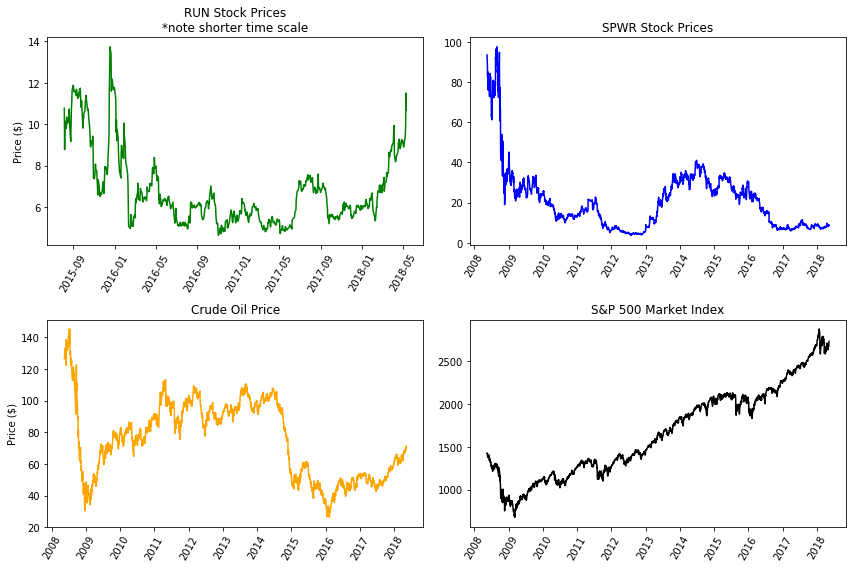

In [375]:
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.plot(df.index, df.run, color='green')
plt.ylabel('Price ($)')
plt.title('RUN Stock Prices\n*note shorter time scale')
plt.xticks(rotation=60)

plt.subplot(222)
plt.plot(df.index, df.spwr, color='blue')
plt.title('SPWR Stock Prices')
plt.xticks(rotation=60)

plt.subplot(223)
plt.plot(df.index, df.oil, color='orange')
plt.ylabel('Price ($)')
plt.title('Crude Oil Price')
plt.xticks(rotation=60)

plt.subplot(224)
plt.plot(df.index, df.sp500, color='black')
plt.title('S&P 500 Market Index')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

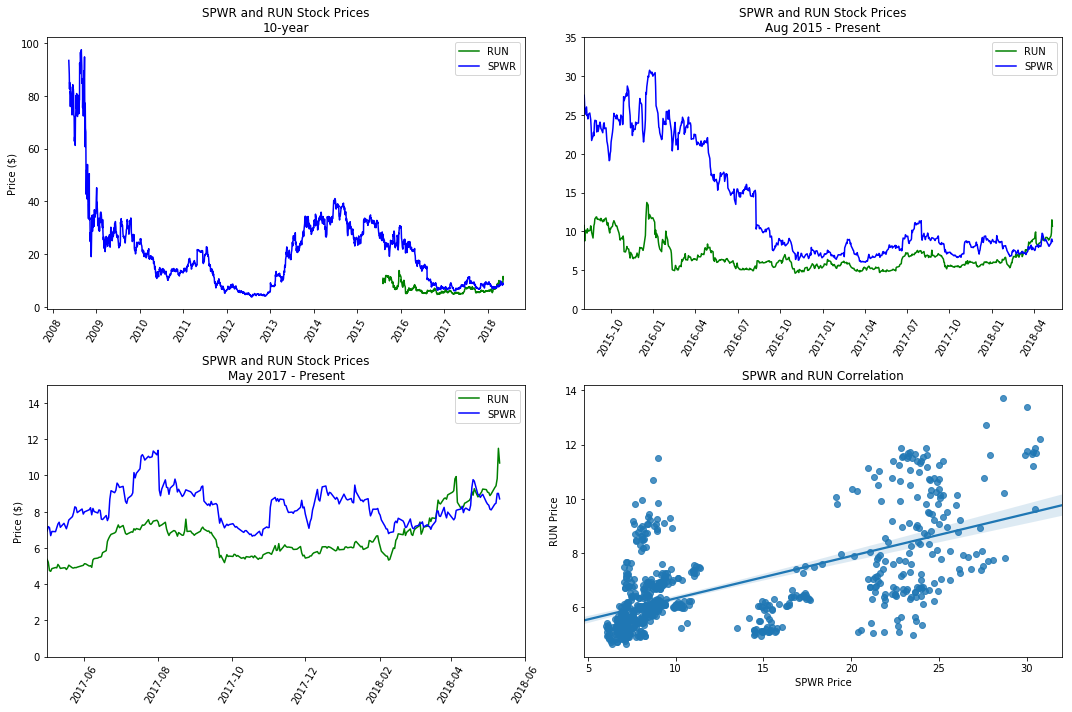

In [378]:
# Stock comparisons between companies

plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(df.index, df.run, label='RUN', color='green')
plt.plot(df.index, df.spwr, label='SPWR', color='blue')
plt.title('SPWR and RUN Stock Prices\n10-year')
plt.ylabel('Price ($)')
plt.xticks(rotation=60)
plt.legend()

plt.subplot(222)
plt.plot(df.index, df.run, label='RUN', color='green')
plt.plot(df.index, df.spwr, label='SPWR', color='blue')
plt.title('SPWR and RUN Stock Prices\nAug 2015 - Present')
plt.xlim([datetime.date(2015, 8, 5), datetime.date(2018, 6, 1)])
plt.ylim(0, 35)
plt.xticks(rotation=60)
plt.legend()

plt.subplot(223)
plt.plot(df.index, df.run, label='RUN', color='green')
plt.plot(df.index, df.spwr, label='SPWR', color='blue')
plt.title('SPWR and RUN Stock Prices\nMay 2017 - Present')
plt.ylabel('Price ($)')
plt.xlim([datetime.date(2017, 5, 1), datetime.date(2018, 6, 1)])
plt.ylim(0, 15)
plt.xticks(rotation=60)
plt.legend()

plt.subplot(224)
sns.regplot(df.spwr, df.run)
plt.title('SPWR and RUN Correlation')
plt.xlabel('SPWR Price')
plt.ylabel('RUN Price')

plt.tight_layout()
plt.show()

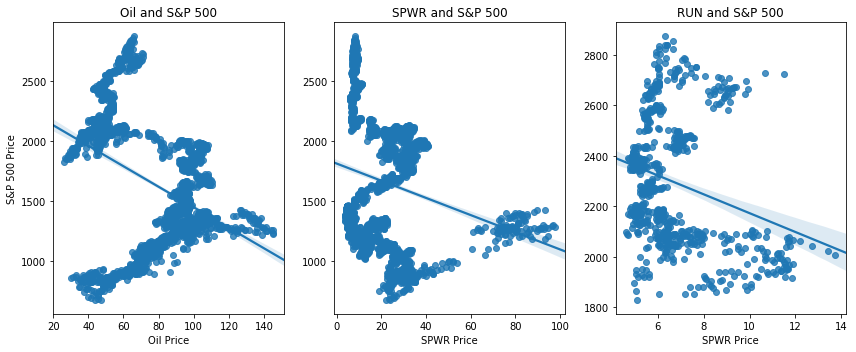

In [379]:
# Correlations with market.  
# Try log transform?
# color code by year?

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
sns.regplot(df.oil, df.sp500)
plt.title('Oil and S&P 500')
plt.ylabel('S&P 500 Price')
plt.xlabel('Oil Price')

plt.subplot(1,3,2)
sns.regplot(df.spwr, df.sp500)
plt.title('SPWR and S&P 500')
plt.xlabel('SPWR Price')
plt.ylabel('')

plt.subplot(1,3,3)
sns.regplot(df.run, df.sp500)
plt.title('RUN and S&P 500')
plt.xlabel('SPWR Price')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [196]:
# Scale to unit prices for better visual comparison since oil/stock price scales are different
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

oil_ = df.oil
oil_ = oil_.values.reshape((len(oil_), 1))
oil_norm = scaler.fit_transform(oil_)

run_ = df.run.dropna()
run_ = run_.values.reshape((len(run_), 1))
run_norm = scaler.fit_transform(run_)

spwr_ = df.spwr
spwr_ = spwr_.values.reshape((len(spwr_), 1))
spwr_norm = scaler.fit_transform(spwr_)

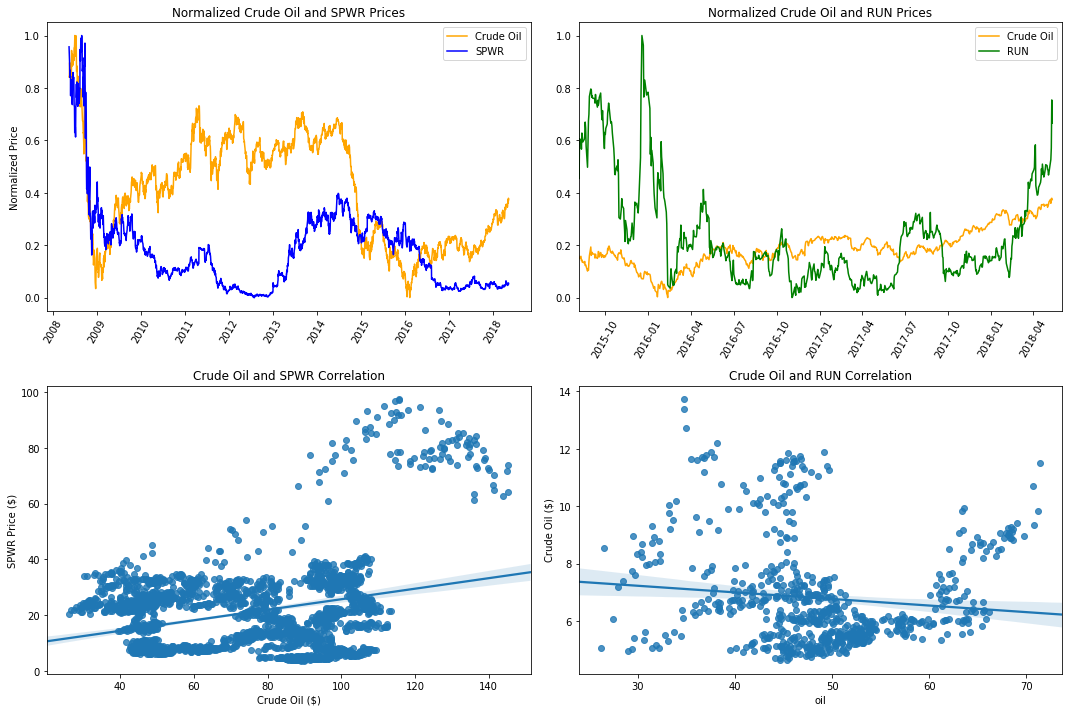

In [380]:
# Stocks / Oil comparison on scaled data

# Customize subplot layout
plt.figure(figsize=(15, 10))

# Crude oil/SPWR
plt.subplot(221)
plt.plot(df.index, oil_norm, label='Crude Oil', color='orange')
plt.plot(df.index, spwr_norm, label='SPWR', color='blue')
plt.title('Normalized Crude Oil and SPWR Prices')
plt.ylabel('Normalized Price')
plt.xticks(rotation=60)
plt.legend()

# Crude oil/RUN
plt.subplot(222)
plt.plot(df.index[len(oil_norm) - len(run_norm):], oil_norm[len(oil_norm) - len(run_norm):], label='Crude Oil', color='orange')
plt.plot(df.index[len(oil_norm) - len(run_norm):], run_norm, label='RUN', color='green')
plt.title('Normalized Crude Oil and RUN Prices')
plt.xticks(rotation=60)
plt.xlim([datetime.date(2015, 8, 5), datetime.date(2018, 6, 1)])
plt.legend()

# Crude oil/SPWR regression
plt.subplot(223)
sns.regplot(df.oil, df.spwr)
plt.title('Crude Oil and SPWR Correlation')
plt.xlabel('Crude Oil ($)')
plt.ylabel('SPWR Price ($)')

# Crude oil/RUN regression
plt.subplot(224)
sns.regplot(df.oil, df.run)
plt.title('Crude Oil and RUN Correlation')
plt.ylabel('Crude Oil ($)')

plt.tight_layout()
plt.show()

In [381]:
# Get regression coefficients for various interactions
print('Oil/SPWR Regression:', stats.linregress(df.oil, df.spwr))
print('\nOil/RUN Regression:', stats.linregress(df.oil[len(df.oil)-len(df.run.dropna()):], df.run.dropna()))
print('\nS&P500/SPWR Regression:', stats.linregress(df.sp500, df.spwr))
print('\nS&P500/RUN Regression:', stats.linregress(df.sp500[len(df.sp500)-len(df.run.dropna()):], df.run.dropna()))
print('\nS&P500/Oil Regression:', stats.linregress(df.sp500, df.oil))
print('\nSPWR/RUN Regression:', stats.linregress(df.spwr[len(df.spwr)-len(df.run.dropna()):], df.run.dropna()))

Oil/SPWR Regression: LinregressResult(slope=0.1884898774443507, intercept=6.903137964822541, rvalue=0.29033881194752675, pvalue=5.252675124136504e-50, stderr=0.01239758194573966)

Oil/RUN Regression: LinregressResult(slope=-0.022962277610504612, intercept=7.9194442204114965, rvalue=-0.10938074085899198, pvalue=0.00381203349487274, stderr=0.007909623928218357)

S&P500/SPWR Regression: LinregressResult(slope=-0.006460014012702892, intercept=31.769147424270436, rvalue=-0.21463804640305104, pvalue=1.4126178959679288e-27, stderr=0.0005866266196385048)

S&P500/RUN Regression: LinregressResult(slope=-0.0018490660768315684, intercept=11.038141192786554, rvalue=-0.2628721576056232, pvalue=1.7009412277742235e-12, stderr=0.0002572493721406281)

S&P500/Oil Regression: LinregressResult(slope=-0.01830363502068996, intercept=105.37268152077161, rvalue=-0.39481489678236137, pvalue=1.6065095829377044e-94, stderr=0.0008500077067265044)

SPWR/RUN Regression: LinregressResult(slope=0.1562638189864759, int

__Exploratory Data Analysis Conclusions:__

* Overall trends
    * Stock and crude oil prices show a lot more volatility than the overall market
* Stock comparisons
    * SPWR prices have dropped considerably in the last decade and are now in the same general vicinity as RUN.  RUN stocks have been on the rise and recently surpassed SPWR.  
    * The prices of RUN and SPWR are positively correlated with an r-squared of 0.623.  This is likely indicative of a general trend in the solar/renewable energy market sector.
* Market correlations of stocks and oil prices
    * Correlation coefficients indicate SPWR, RUN, and oil prices indicate negative correlations with the S&P 500 Index; however, looking at the regression plots shows no real correlation and appears to reflect the large degree of volatility in both the individual stocks and price of oil.  
* Relationship of stocks to oil prices:
    * Mixed results indicating no clear correlation; likely a result of volatility 
    * SPWR and oil prices have a weak positive correlation (r^2 = 0.290)
    * RUN and oil prices have a weak negative correlation (r^2 = -0.109)

## Time-Series Analysis
 
Time-series decomposition allows us to see systematic patterns in the data. Consistent or reoccuring components can be described and directly modeled.  Decomposition components include:
* Trend: direction and magnitude of overall change
* Seasonality: repeating cycles over a shorter period of time
* Residuals: random variation in the time-series (non-systematic) 

Stats models seasonal_decompose provides an naive decomposition using either an additive (linear) or multiplicative (non-linear) model.

__Seasonal Decomposition__

In [332]:
from statsmodels.tsa.seasonal import seasonal_decompose

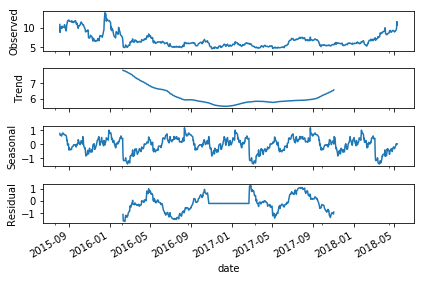

In [975]:
# Frequency and interpretation of these plots?
# frequency has large effect (1 vs 5 vs 7 vs 365?)
# Trend simply smoothed moving average?

# Weekly 
run_decompose = seasonal_decompose(df.run.dropna(), model='additive', freq=(52*5))
run_decompose.plot()
plt.show()

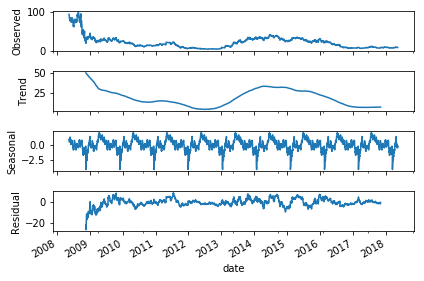

In [974]:
spwr_decompose = seasonal_decompose(df.spwr, model='additive', freq=(52*5))
spwr_decompose.plot()
plt.show()

## Modeling

__Train/Test Data Split__

Try out with 30 day and 90 day hold out sets.  

In [820]:
# Take last 30 days of data as test set
run_train30 = df.run[:-30].dropna()
run_test30 = df.run[-30:]
print('RUN train:', len(run_train30), 
      '\nRUN test:', len(run_test30), 
      '\nFraction of total data set:', len(run_test30)/len(run.dropna()))

spwr_train30 = df.spwr[:-30]
spwr_test30 = df.spwr[-30:]
print('\nSPWR train:', len(spwr_train30), 
      '\nSPWR test:', len(spwr_test30),
     '\nFraction of total data set:', len(spwr_test30)/len(spwr.dropna()))

RUN train: 668 
RUN test: 30 
Fraction of total data set: 0.04297994269340974

SPWR train: 2483 
SPWR test: 30 
Fraction of total data set: 0.011918951132300357


In [821]:
# Take last 90 days of data as test set
run_train90 = df.run[:-90].dropna()
run_test90 = df.run[-90:]
print('RUN train:', len(run_train90), 
      '\nRUN test:', len(run_test90), 
      '\nFraction of total data set:', len(run_test90)/len(run.dropna()))

spwr_train90 = df.spwr[:-90]
spwr_test90 = df.spwr[-90:]
print('\nSPWR train:', len(spwr_train90), 
      '\nSPWR test:', len(spwr_test90),
     '\nFraction of total data set:', len(spwr_test90)/len(spwr.dropna()))

RUN train: 608 
RUN test: 90 
Fraction of total data set: 0.12893982808022922

SPWR train: 2423 
SPWR test: 90 
Fraction of total data set: 0.03575685339690107


__Stationarity__

Stationarity tests for mean and variance stability.  A data set is considered stationary if the mean and variance are not time dependent.  

ADF is a formal statistical test for stationarity.  The null hypothesis assumes non-stationarity.  If p < 0.05, reject the null and assume alternate hypothesis of stationarity.  If p > 0.05, accept the null of non-stationarity.

Check stationarity of various training data sets.

In [429]:
from statsmodels.tsa.stattools import adfuller

In [765]:
# Write function to teste for stationarity
def stationarity_test(name, x):
    result = adfuller(x)
    print(name,':')
    print('ADF Statistic %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print('{} data set is NOT stationary, differencing required!\n'.format(name))
    else:
        print('{} is stationary, hooray!\n'.format(name))

In [766]:
stationarity_test('RUN 30', run_train30)
stationarity_test('SPWR 30', spwr_train30)

RUN 30 :
ADF Statistic -2.910445
p-value: 0.044147
RUN 30 is stationary, hooray!

SPWR 30 :
ADF Statistic -4.020752
p-value: 0.001306
SPWR 30 is stationary, hooray!



In [767]:
stationarity_test('RUN 90', run_train90)
stationarity_test('SPWR 90', spwr_train90)

RUN 90 :
ADF Statistic -2.859578
p-value: 0.050254
RUN 90 data set is NOT stationary, differencing required!

SPWR 90 :
ADF Statistic -4.001842
p-value: 0.001401
SPWR 90 is stationary, hooray!



## ARIMA Models

__ACF/PACF Plots__

In [563]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [611]:
def autocorrelation_model(name, x):
    plot_acf(pd.Series(x), lags=50, alpha=.05)
    plt.title('{} - Autocorrelation Function'.format(name))
    plt.show()

    plot_pacf(pd.Series(x), lags=50, alpha=0.05)
    plt.title('{} - Partial Autocorrelation Function'.format(name))
    plt.show()

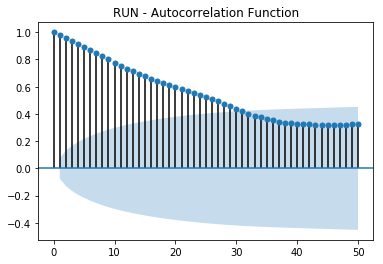

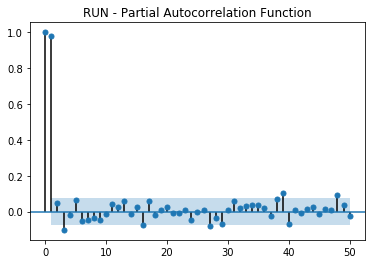

In [612]:
# ACF/PACF for RUN
autocorrelation_model('RUN', run_train)

For RUN, acf shows high correlation for a lag period of up to 30 days.  The pacf shows strong correlation only for a lag period of 1 day.  95% confidence intervals are plotted.

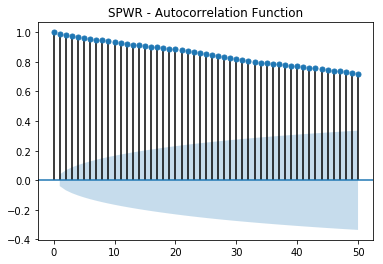

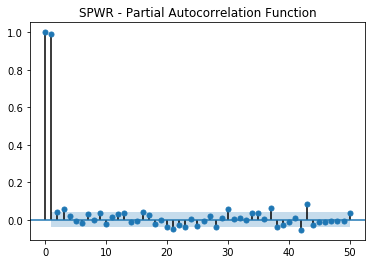

In [613]:
# ACF/PACF for SPWR
autocorrelation_model('SPWR', spwr_train)

For SPWR, acf shows high correlation for a lag period well beyond the 50 day cutoff. Limit grid search to 10.  The pacf shows strong correlation only for a lag period of 1 day.  Again, 95% confidence intervals are shown.

Reasonable grid search parameters for each ARIMA model:
* AR(p) = [1]
* I(d) = [0, 1]
* MA(q) = range(10)

__Iterate and Evaluate ARIMA Models__

Create functions to test various ARIMA configurations.  Evaluate models using MSE for predicted values vs. test set values.  Best model configurations minimize MSE.  Evaluate residuals of best performing configurations.

In [859]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Function to generate predictions for a given arima order
def evaluate_arima(train, test, arima_order):
    # Populate history based on training set
    history = [x for x in train]
    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Use rolling one-step predictions.  Fit model using history,
    # adding each prediction to history to continue forecasting
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        
        # Get prediction
        y_pred = model_fit.forecast()[0]
        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
    
    error = mean_squared_error(test, predictions)
    return error

# Function to determine best arima order combination based on lowest MSE
def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
    
    best_score = float('inf') 
    best_config = None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                arima_order = (p, d, q)
                try:
                    mse = evaluate_arima(train, test, arima_order)
                    if mse < best_score:
                        best_score, best_config = mse, arima_order
                    print('ARIMA config: {}; MSE:{}'.format(arima_order, mse))
                except (ValueError, np.linalg.LinAlgError): # ignore non converging errors
                    pass
    
    print('Best ARIMA config:', best_config)
    print('MSE:', best_score)

# Function to evaluate residuals
def plot_residuals(name, train, p, d, q):
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    residuals = model_fit.resid
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('{}: {},{},{} Residuals'.format(name, p, d, q))
    residuals.plot()
    
    plt.subplot(1,2,2)
    residuals.hist(bins=25)
    plt.title('{} Residual Histogram'.format(name))
    plt.show()

# Function to plot predictions
def plot_predictions(name, train, test, p, d, q):
    
    arima_order = (p,d,q)
    
    history = [x for x in train]
    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Recreate evaluate_arima model.  Need to do this instead of calling existing model
    # to return predictions list
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        
        # Get prediction
        y_pred = model_fit.forecast()[0]
        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
     
    # Plots
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{} Prediction Validation: - Full Time Series'.format(name))
    plt.ylabel('Price ($)')
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.subplot(122)
    plt.autoscale()
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{} Prediction Validation - 2018'.format(name))
    plt.ylabel('Price ($)')
    plt.ylim(min(predictions) - 5, max(predictions) + 5)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 6, 1)])
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.tight_layout()

__RUN Stock__

In [795]:
# Fit and test RUN ARIMA model- 30 day test period
arima_gridsearch(run_train30, run_test30, range(3), range(2), range(0, 11, 2))

ARIMA config: (0, 0, 0); MSE:6.396473275334917
ARIMA config: (0, 0, 2); MSE:6.070439630760343
ARIMA config: (0, 0, 4); MSE:5.739538119711451
ARIMA config: (0, 0, 6); MSE:5.440911729321038
ARIMA config: (0, 0, 8); MSE:5.232980123005033
ARIMA config: (0, 0, 10); MSE:5.052318301126101
ARIMA config: (0, 1, 0); MSE:0.5495855655272354
ARIMA config: (0, 1, 2); MSE:0.5425930445343998
ARIMA config: (0, 1, 4); MSE:0.5572949502843467
ARIMA config: (0, 1, 6); MSE:0.5488807860782042
ARIMA config: (0, 1, 8); MSE:0.5071949888614767
ARIMA config: (0, 1, 10); MSE:0.5630463171013843
ARIMA config: (1, 0, 0); MSE:0.8378280569544168
ARIMA config: (1, 0, 2); MSE:0.945424191720726
ARIMA config: (1, 0, 4); MSE:0.9131312931270847
ARIMA config: (1, 0, 6); MSE:0.9578740895432862
ARIMA config: (1, 0, 8); MSE:1.1088504699632316
ARIMA config: (1, 0, 10); MSE:1.0556430514510151
ARIMA config: (1, 1, 0); MSE:0.5450812541824438
ARIMA config: (2, 0, 0); MSE:0.8911193352647435
ARIMA config: (2, 0, 2); MSE:0.9478061934417

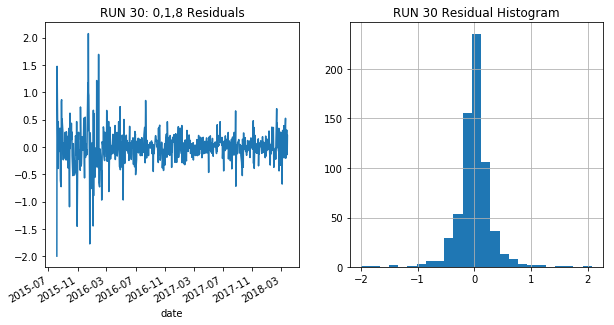

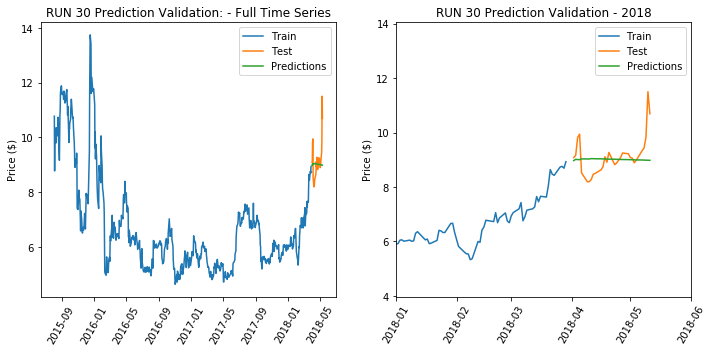

In [977]:
plot_residuals('RUN 30', run_train30, 0, 1, 8)
plot_predictions('RUN 30', run_train30, run_test30, 0, 1, 8)

In [737]:
# Fit and test RUN ARIMA model - 90 day test period
arima_gridsearch(run_train90, run_test90, range(3), range(2), range(0, 11, 2))

ARIMA config: (0, 0, 0); MSE:2.701114698123787
ARIMA config: (0, 0, 2); MSE:2.677523213031734
ARIMA config: (0, 0, 4); MSE:2.65376013963503
ARIMA config: (0, 0, 6); MSE:2.6328885287169803
ARIMA config: (0, 0, 8); MSE:2.6239356940262755
ARIMA config: (0, 0, 10); MSE:2.6049607483288315
ARIMA config: (0, 1, 0); MSE:6.515424693257733
ARIMA config: (0, 1, 2); MSE:6.608047346474705
ARIMA config: (0, 1, 4); MSE:6.6120395429982635
ARIMA config: (0, 1, 6); MSE:6.62279600817648
ARIMA config: (0, 1, 8); MSE:6.766649975280281
ARIMA config: (0, 1, 10); MSE:6.648921651581522
ARIMA config: (1, 0, 0); MSE:2.831793007078401
ARIMA config: (1, 0, 2); MSE:2.695182339964694
ARIMA config: (1, 0, 4); MSE:2.7673139108442735
ARIMA config: (1, 0, 6); MSE:2.727162386610617
ARIMA config: (1, 0, 8); MSE:2.571105185966798
ARIMA config: (1, 0, 10); MSE:2.5953689673943403
ARIMA config: (1, 1, 0); MSE:6.559854618909705
ARIMA config: (2, 0, 0); MSE:2.741721750386134
ARIMA config: (2, 1, 0); MSE:6.5959881225560215
Best 

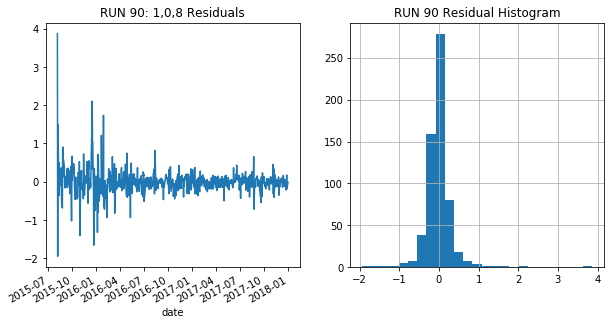

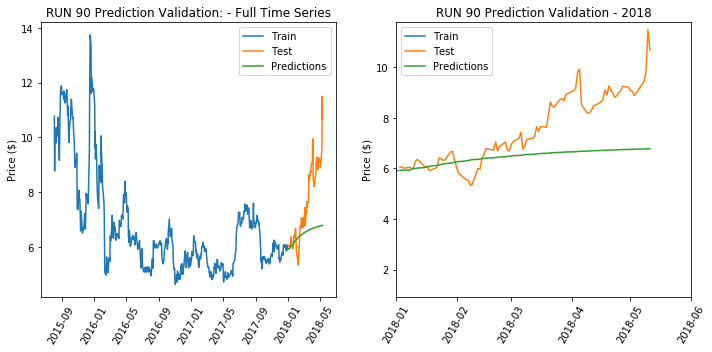

In [861]:
plot_residuals('RUN 90', run_train90, 1, 0, 8)
plot_predictions('RUN 90', run_train90, run_test90, 1, 0, 8)

__SPWR Stock__

In [730]:
# Fit and test SPWR ARIMA model - 30 day test period
arima_gridsearch(spwr_train30, spwr_test30, range(3), range(2), range(0, 10, 2))

ARIMA config: (0, 0, 0); MSE:161.38011875387164
ARIMA config: (0, 0, 2); MSE:154.02302719748468
ARIMA config: (0, 0, 4); MSE:148.83785194209534
ARIMA config: (0, 1, 0); MSE:1.6342378771462838
ARIMA config: (0, 1, 2); MSE:1.683375386091741
ARIMA config: (0, 1, 4); MSE:1.6648066641833197
ARIMA config: (0, 1, 6); MSE:1.6733627982168509
ARIMA config: (0, 1, 8); MSE:1.6373339204465318
ARIMA config: (1, 0, 0); MSE:0.2339036282526451
ARIMA config: (1, 0, 2); MSE:0.27799006780619456
ARIMA config: (1, 0, 4); MSE:0.25470989331044186
ARIMA config: (1, 0, 6); MSE:0.26583678995114907
ARIMA config: (1, 0, 8); MSE:0.255476583396446
ARIMA config: (1, 1, 0); MSE:1.6581237651543146
ARIMA config: (1, 1, 2); MSE:1.6868919682255974
ARIMA config: (1, 1, 4); MSE:1.6657984274236433
ARIMA config: (2, 0, 0); MSE:0.24074947513918804
ARIMA config: (2, 0, 2); MSE:0.27651727475759
ARIMA config: (2, 0, 4); MSE:0.2550836838991872
ARIMA config: (2, 1, 0); MSE:1.684243565594809
ARIMA config: (2, 1, 2); MSE:1.6289866569

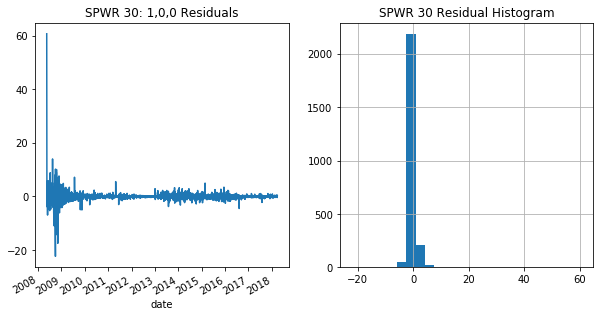

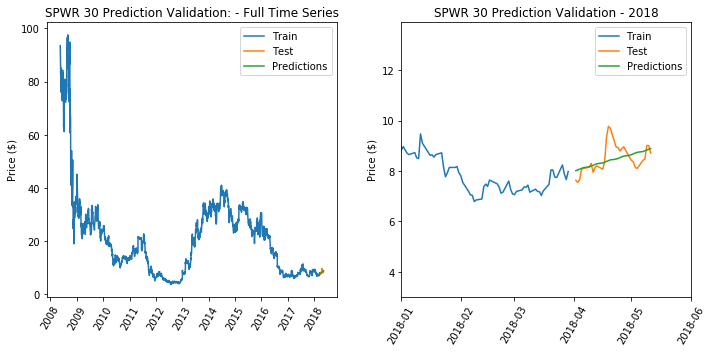

In [862]:
plot_residuals('SPWR 30', spwr_train30, 1, 0, 0)
plot_predictions('SPWR 30', spwr_train30, spwr_test30, 1, 0, 0)

In [740]:
# Fit and test SPWR ARIMA model - 90 day test period
arima_gridsearch(spwr_train90, spwr_test90, range(3), range(2), range(0, 10, 2))

ARIMA config: (0, 0, 0); MSE:183.00178798316952
ARIMA config: (0, 0, 2); MSE:181.5026589277695
ARIMA config: (0, 0, 4); MSE:180.42920000411507
ARIMA config: (0, 1, 0); MSE:1.9524397367136086
ARIMA config: (0, 1, 2); MSE:1.992039799114087
ARIMA config: (0, 1, 4); MSE:1.9967744720064158
ARIMA config: (0, 1, 6); MSE:1.982592960700586
ARIMA config: (0, 1, 8); MSE:1.9966419571665828
ARIMA config: (1, 0, 0); MSE:6.300201374371335
ARIMA config: (1, 0, 2); MSE:4.195669996210218
ARIMA config: (1, 0, 4); MSE:4.948347746075656
ARIMA config: (1, 0, 6); MSE:4.523290492336644
ARIMA config: (1, 0, 8); MSE:4.722046608455163
ARIMA config: (1, 1, 0); MSE:1.972481900857367
ARIMA config: (1, 1, 2); MSE:1.993479953154176
ARIMA config: (1, 1, 4); MSE:1.996502040283242
ARIMA config: (2, 0, 0); MSE:5.6380136913190455
ARIMA config: (2, 0, 2); MSE:4.255512589894541
ARIMA config: (2, 0, 4); MSE:4.9349964100227215
ARIMA config: (2, 1, 0); MSE:1.9956778381966342
Best ARIMA config: (0, 1, 0)
MSE: 1.9524397367136086

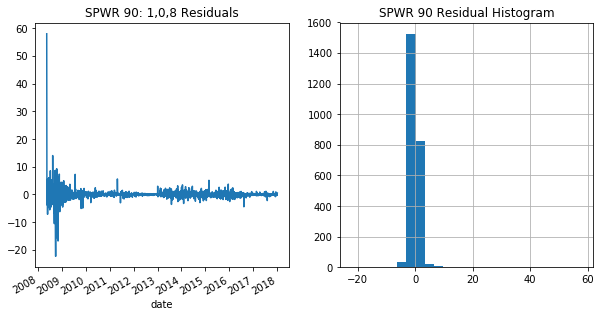

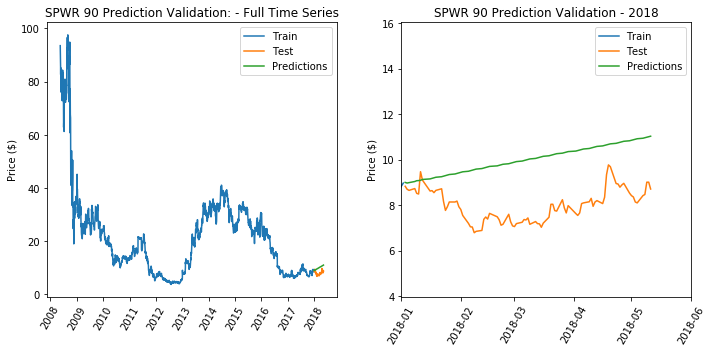

In [863]:
plot_residuals('SPWR 90', spwr_train90, 1, 0, 8)
plot_predictions('SPWR 90', spwr_train90, spwr_test90, 1, 0, 8)

## Prophet

In [864]:
from fbprophet import Prophet

In [1236]:
# Prophet requires specific input format.  
# Columns names must be lowercase, date as 'ds', data as 'y'
run_prophet = run.dropna().rename(columns={'date': 'ds', 'run': 'y'})

#spwr_prophet = spwr
spwr_prophet = spwr.rename(columns={'date': 'ds', 'spwr': 'y'})

### RUN Stock

In [1238]:
run_prophet.head()

,ds,y
1,2018-05-11,10.69
2,2018-05-10,11.50
3,2018-05-09,9.83
4,2018-05-08,9.43
5,2018-05-07,9.33


__Forecast Entire Data Set - No Hold Out Validation__

In [1204]:
# Model with default parameters
run_model = Prophet(daily_seasonality=False)
run_model.fit(run_prophet)
run_future = run_model.make_future_dataframe(periods=365)
run_forecast = run_model.predict(run_future)

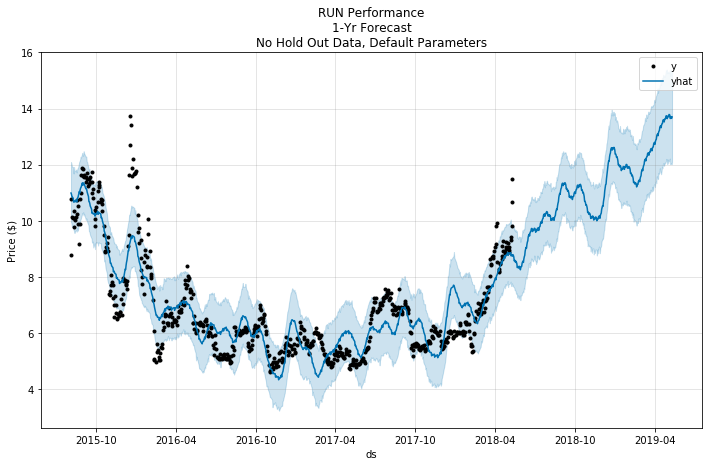

In [1205]:
# Plot 
run_model.plot(run_forecast)
plt.title('RUN Performance\n1-Yr Forecast\nNo Hold Out Data, Default Parameters')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Using all available data, price is expected to rise substantially.  Peak value one year out near $14/share

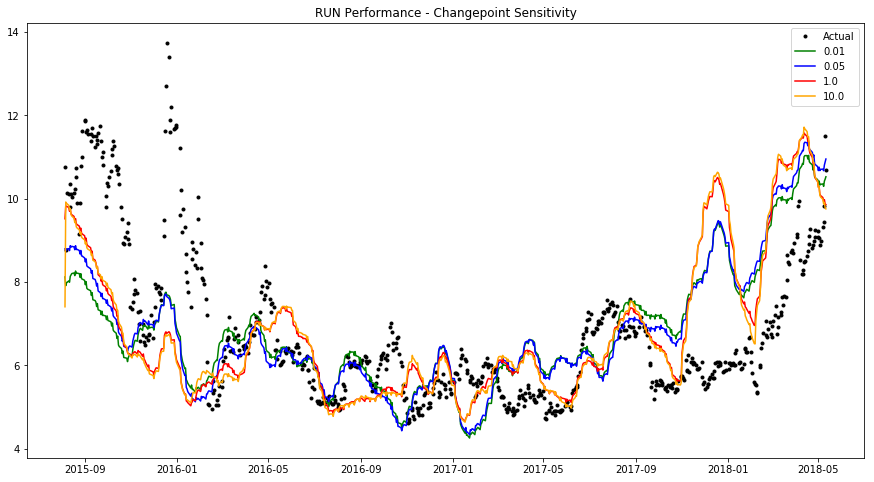

In [1166]:
# Evaluate across range of changepoint sensitivity
changepoints = [0.01, 0.05, 1.0, 10.0]

for cp in changepoints:
    model = Prophet(daily_seasonality=False, changepoint_prior_scale=cp)
    model.fit(run_prophet)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    run_prophet[cp] = forecast['yhat']

# Plot results
plt.figure(figsize=(15,8))

# Acual observations
plt.plot(run_prophet['ds'], run_prophet['y'], '.', color='black', label='Actual')

# Different changepoints
colors = {0.01: 'g', 0.05: 'b', 1.0: 'r', 10.0: 'orange'}
for cp in changepoints:
    plt.plot(run_prophet['ds'], run_prophet[cp], color=colors[cp], label=cp)

plt.title('RUN Performance - Changepoint Sensitivity')
plt.legend()
plt.show()

No changepoint value appears to fit the data particularly well.  Stick with default parameter (0.05) for remainder of analysis.

In [1173]:
# Get changepoint dates
# Model specifies 25 potential changepoints and places them 
# uniformly in the first 80% of the time series
# How is this useful data if it's uniformly distributed?
run_model.changepoints

22    2015-09-04
45    2015-10-08
67    2015-11-09
89    2015-12-10
112   2016-01-14
134   2016-02-17
156   2016-03-18
179   2016-04-21
201   2016-05-23
223   2016-06-23
246   2016-07-27
268   2016-08-26
290   2016-09-28
312   2016-10-28
335   2016-12-01
357   2017-01-04
379   2017-02-06
402   2017-03-10
424   2017-04-11
446   2017-05-12
469   2017-06-15
491   2017-07-18
513   2017-08-17
536   2017-09-20
558   2017-10-20
Name: ds, dtype: datetime64[ns]

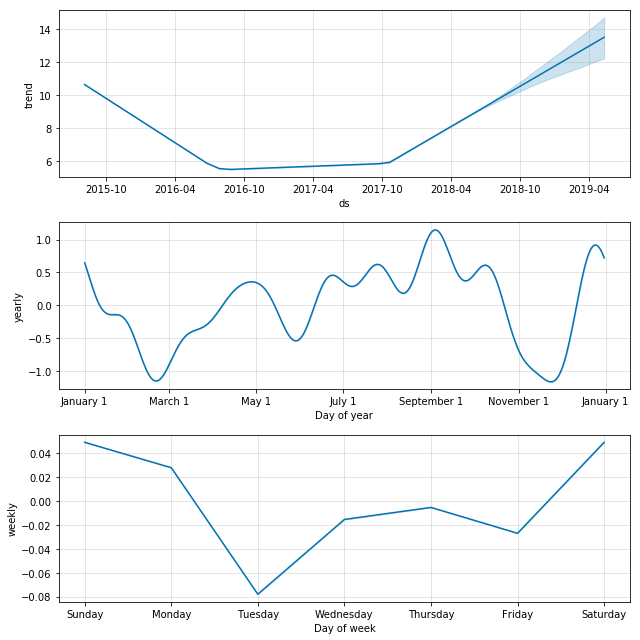

In [1162]:
# Get decomposition components
model.plot_components(run_forecast)
plt.show()

# Increasing trend.  Monthly trend noise.  Weekly doesn't make much sense, why are weekends highest value?

__Validate RUN Predictions__

In [1194]:
# Validaate model predictions by splitting available data into train/test sets
# Take last 30 days as test data
train = run_prophet[30:]
test = run_prophet[:30]

train.head()

,ds,y
31,2018-03-29,8.93
32,2018-03-28,8.69
33,2018-03-27,8.76
34,2018-03-26,8.73
35,2018-03-23,8.43


In [1199]:
# Fit model with training data, make 30 days of predictions 
train_model = Prophet(daily_seasonality=False)
train_model.fit(train);
future = train_model.make_future_dataframe(periods=365)
forecast = train_model.predict(future)

In [1200]:
forecast[['ds', 'yhat']].tail()

,ds,yhat
1028,2019-03-25,9.213105
1029,2019-03-26,9.091289
1030,2019-03-27,9.134692
1031,2019-03-28,9.125804
1032,2019-03-29,9.103484


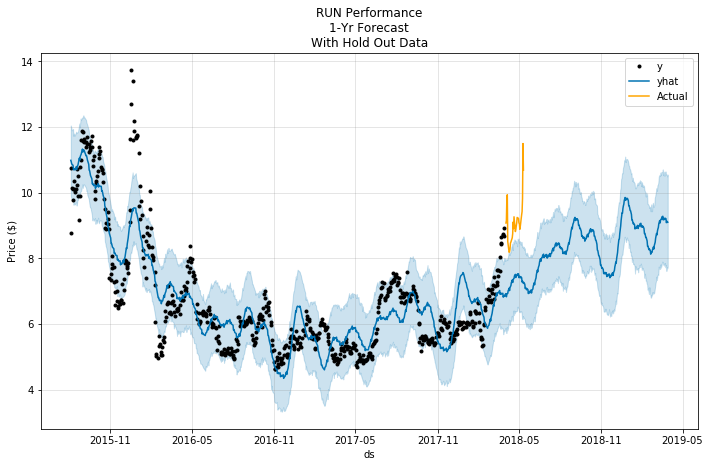

In [1202]:
# Plot forecasted results based on training data.  Compare to actual.  Note truncating training data set
# greatly impacted one-year outlook.  Max value now just under $10/share and peak occurs earlier (1/2019 vs 5/2019 above)
# Model highly unstable

train_model.plot(forecast)
plt.plot(test['ds'], test['y'], label='Actual', color='orange')
plt.title('RUN Performance\n1-Yr Forecast\nWith Hold Out Data')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

MSE: 3.9718174254251815


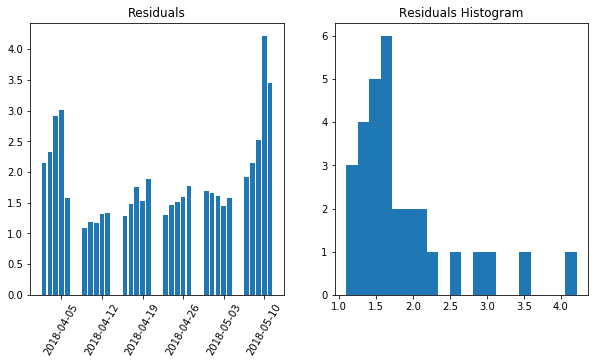

In [1274]:
# Calculate MSE 
results = forecast[['ds', 'yhat']].merge(test, on='ds')
print('MSE:', mean_squared_error(results.y, results.yhat))

# Calculate residuals
results['residual'] = results['y'] - results['yhat']

# Plot results
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.bar(results.ds, results.residual)
plt.title('Residuals')
plt.xticks(rotation=60)

plt.subplot(122)
plt.hist(results.residual, bins=20)
plt.title('Residuals Histogram')

plt.show()

### SPWR Stock

In [1239]:
spwr_prophet.head()

,ds,y
1,2018-05-11,8.71
2,2018-05-10,9.01
3,2018-05-09,9.01
4,2018-05-08,8.47
5,2018-05-07,8.42


__Forecast Entire Data Set - No Hold Out Validation__

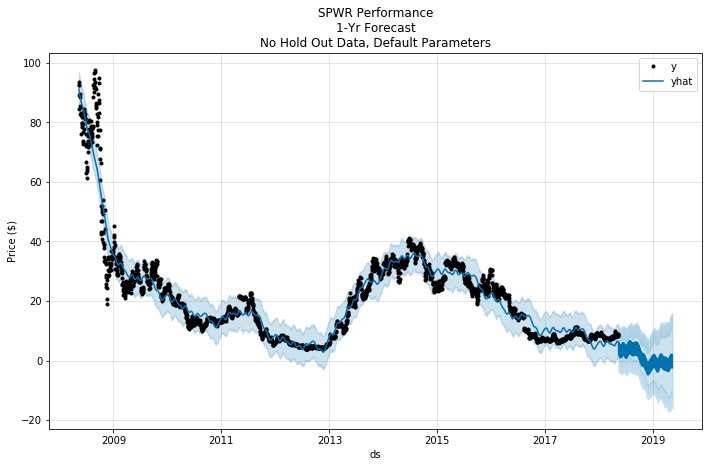

In [1240]:
# Model with default parameters
spwr_model = Prophet(daily_seasonality=False)
spwr_model.fit(spwr_prophet)
spwr_future = spwr_model.make_future_dataframe(periods=365)
spwr_forecast = spwr_model.predict(spwr_future)

# Plot 
spwr_model.plot(spwr_forecast)
plt.title('SPWR Performance\n1-Yr Forecast\nNo Hold Out Data, Default Parameters')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Using all available data, price is expected to drop to negative values.

In [ ]:
# Evaluate across range of changepoint sensitivity
changepoints = [0.01, 0.05, 1.0, 10.0]

for cp in changepoints:
    model = Prophet(daily_seasonality=False, changepoint_prior_scale=cp)
    model.fit(run_prophet)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    run_prophet[cp] = forecast['yhat']

# Plot results
plt.figure(figsize=(15,8))

# Acual observations
plt.plot(run_prophet['ds'], run_prophet['y'], '.', color='black', label='Actual')

# Different changepoints
colors = {0.01: 'g', 0.05: 'b', 1.0: 'r', 10.0: 'orange'}
for cp in changepoints:
    plt.plot(run_prophet['ds'], run_prophet[cp], color=colors[cp], label=cp)

plt.title('RUN Performance - Changepoint Sensitivity')
plt.legend()
plt.show()

No changepoint value appears to fit the data particularly well.  Stick with default parameter (0.05) for remainder of analysis.

# Get changepoint dates
# Model specifies 25 potential changepoints and places them 
# uniformly in the first 80% of the time series
# How is this useful data if it's uniformly distributed?
run_model.changepoints

# Get decomposition components
model.plot_components(run_forecast)
plt.show()

# Increasing trend.  Monthly trend noise.  Weekly doesn't make much sense, why are weekends highest value?

__Validate RUN Predictions__

# Validaate model predictions by splitting available data into train/test sets
# Take last 30 days as test data
train = run_prophet[30:]
test = run_prophet[:30]

train.head()

# Fit model with training data, make 30 days of predictions 
train_model = Prophet(daily_seasonality=False)
train_model.fit(train);
future = train_model.make_future_dataframe(periods=365)
forecast = train_model.predict(future)

forecast[['ds', 'yhat']].tail()

# Plot forecasted results based on training data.  Compare to actual.  Note truncating training data set
# greatly impacted one-year outlook.  Max value now just under $10/share and peak occurs earlier (1/2019 vs 5/2019 above)
# Model highly unstable

train_model.plot(forecast)
plt.plot(test['ds'], test['y'], label='Actual', color='orange')
plt.title('RUN Performance\n1-Yr Forecast\nWith Hold Out Data')
plt.ylabel('Price ($)')
plt.legend()
plt.show()